# Credit Card Dataset — Data Analytics Roadmap (Notebook)
## Purpose
A step-by-step notebook scaffold for your assignment:
Data cleaning → Data integration → Data reduction → Normalization → Hypothesis testing → Visualization

Dataset: Kaggle — 'Credit Card' (Mishra5001). If you haven't downloaded the CSV, see the cell below.

Citation: Kaggle dataset page.

## PROBLEM STATEMENT
The company wants to understand driving factors behind loan default. Using the provided credit dataset, perform a full data analytics pipeline: data cleaning, integration, reduction, normalization, statistical hypothesis testing, and data visualization. Produce reproducible Python code and brief explanations for each step.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from scipy import stats

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

## Load dataset

In [3]:
app_csv = "datasets/application_data.csv" # main table
prev_csv = "datasets/columns_description.csv" # previous loans
col_csv = "datasets/previous_application.csv" # columns description


# 1) Load data
app = pd.read_csv(app_csv, encoding='utf-8')
prev = pd.read_csv(prev_csv, encoding='latin1')
col = pd.read_csv(col_csv, encoding='utf-8')


print('Shapes: ', app.shape, prev.shape, col.shape)


# Quick head
display(app.head())
display(prev.head())
display(col.head())

Shapes:  (307511, 122) (160, 5) (1670214, 37)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


,Unnamed: 0,Table,Row,Description,Special
0,1,application_data,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_data,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_data,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_data,CODE_GENDER,Gender of the client,NaN
4,7,application_data,FLAG_OWN_CAR,Flag if the client owns a car,NaN


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

In [10]:
dataframes = {'application': app, 'previous': prev, 'column': col}

for name, df in dataframes.items():
    print('\n--', name, '--')
    print("Shape before pre-processing:", df.shape)
    print('\nMissing % per column (top 10):')
    missing_percent = df.isnull().sum() / len(df)
    cols_to_drop = missing_percent[missing_percent > 0.4].index
    print(f"Dropping {len(cols_to_drop)} columns with >40% missing values")

    dataframes[name] = df.drop(columns=cols_to_drop)
    print("Shape after pre-processing:", dataframes[name].shape)

app = dataframes['application']
prev = dataframes['previous']
col = dataframes['column']


-- application --
Shape before pre-processing: (307511, 122)

Missing % per column (top 10):
Dropping 49 columns with >40% missing values
Shape after pre-processing: (307511, 73)

-- previous --
Shape before pre-processing: (160, 5)

Missing % per column (top 10):
Dropping 1 columns with >40% missing values
Shape after pre-processing: (160, 4)

-- column --
Shape before pre-processing: (1670214, 37)

Missing % per column (top 10):
Dropping 11 columns with >40% missing values
Shape after pre-processing: (1670214, 26)


In [11]:
print(app.shape)
print(prev.shape)
print(col.shape)

display(app.head())
display(prev.head())
display(col.head())

(307511, 73)
(160, 4)
(1670214, 26)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


,Unnamed: 0,Table,Row,Description
0,1,application_data,SK_ID_CURR,ID of loan in our sample
1,2,application_data,TARGET,Target variable (1 - client with payment diffi...
2,5,application_data,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,6,application_data,CODE_GENDER,Gender of the client
4,7,application_data,FLAG_OWN_CAR,Flag if the client owns a car


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,17145.0,SATURDAY,15,Y,...,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,607500.0,THURSDAY,11,Y,...,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,112500.0,TUESDAY,11,Y,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,450000.0,MONDAY,7,Y,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,337500.0,THURSDAY,9,Y,...,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high


## Visualising the Distribution of Loan Defaulters and Non-Defaulters

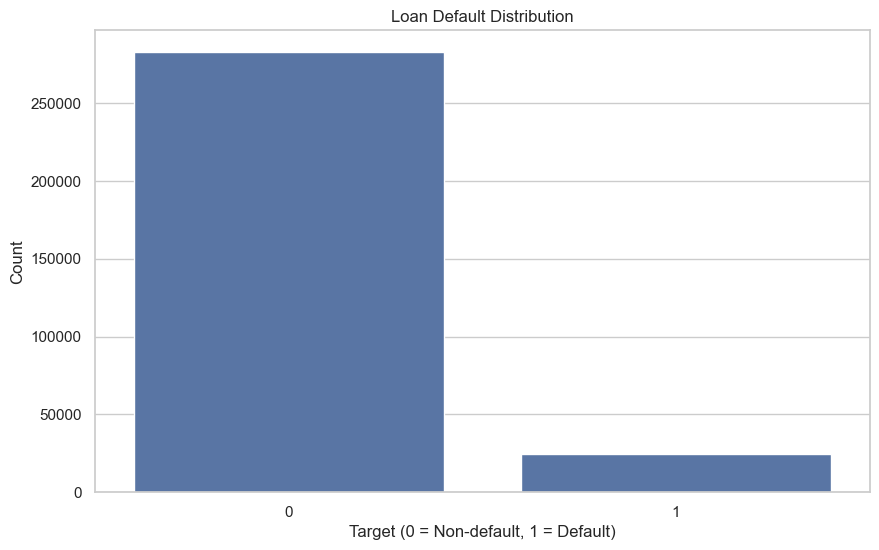

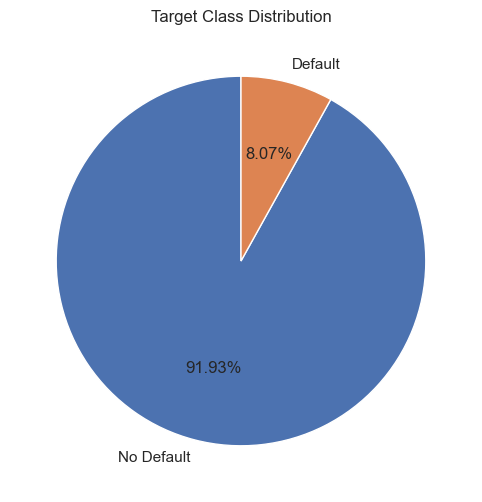

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check target balance
sns.countplot(x='TARGET', data=app)
plt.title("Loan Default Distribution")
plt.xlabel("Target (0 = Non-default, 1 = Default)")
plt.ylabel("Count")
plt.show()

# Class imbalance
app['TARGET'].value_counts(normalize=True).plot(kind='pie', autopct='%1.2f%%', labels=['No Default', 'Default'], startangle=90)
plt.title("Target Class Distribution")
plt.ylabel("")
plt.show()